Выполнил:
Беляев Степан Константинович

#  Практика 4: Атака DeepLift на модели ИИ



## Шаг 1: Загрузка обученной модели и данных MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9738 - loss: 0.0893
Test accuracy on clean images: 0.9767000079154968


## Шаг 2: Теория атаки PGD


Projected Gradient Descent (PGD) — это итеративный метод, используемый в состязательном машинном обучении для создания состязательных примеров. Это входные данные для моделей машинного обучения, которые злоумышленник намеренно разрабатывает, чтобы модель сделала ошибку. Заключается он в применении небольших, но итеративно регулируемых возмущений к входным данным, направленных на максимизацию ошибки предсказания модели. Злоумышленник может контролировать размер этих возмущений и количество итераций, что позволяет соблюдать баланс между эффективностью состязательных примеров и их незаметностью.

## Шаг 3: Реализация атаки PGD с использованием Foolbox

In [2]:
# установка Foolbox
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.9 MB/s eta 0:00:00


In [3]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn

In [13]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Выполнение атаки
attack = fb.attacks.LinfPGD()
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку в тензор с размерностью (1,)

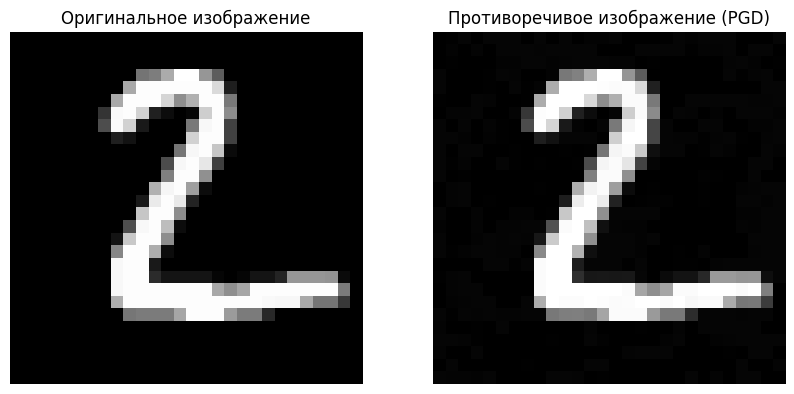

In [14]:
# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")  # Предполагается, что advs имеет правильную форму
plt.axis('off')

plt.show()

# Шаг 4: Оценка модели на противоречивых примерах

In [10]:
adversarial_images = []
# Обработка изображений
for i in range(len(test_images) // 10): # ограничил выборку для ускорения выполнения
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    # Атака на изображение
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)
# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)
# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:1000])
print(f'Accuracy on adversarial examples (PGD attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0081 - loss: 14.1807     
Accuracy on adversarial examples (PGD attack): 0.009999999776482582


## Вывод

Вывод: Точность снизилась с 97.5% на тестовых изображениях до 0.01% при eps = 0.01 на атакованных, что указывает на уязвимость модели перед PGD. Эта атака, несмотря на итеративный характер, минимальными изменениями значительно снижает точность модели.
